<a href="https://colab.research.google.com/github/GerardoFesta/DLforJITDefectPrediction/blob/main/src/LeaveOneProjectOut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from cmath import e
import pandas as pd
import torch

from torch import nn
from torch.utils.data import Dataset

import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skmetrics 
!pip install torchmetrics
from torchmetrics import AUROC
import matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 4.6 MB/s 


In [2]:
from torch import nn
import torch
import torch.nn.functional as F


class BinaryClassificator(nn.Module):
  def __init__(self, in_size: int, hidden_size: int, num_classes: int):
    super(BinaryClassificator, self).__init__()

    self.fc1 = nn.Linear(in_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x: torch.Tensor):

    out_1 = self.fc1(x)

    out_2 = F.tanh(out_1)
    out_2_2 = F.tanh(out_2)

    out_3 = self.fc2(out_2)

    return out_3

In [3]:
from torch.utils.data import Dataset
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [4]:
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np

class CustomScaler(BaseEstimator,TransformerMixin): 
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y = None):
        self.scaler.fit(X[:, :-1], y)
        return self

    def transform(self, X):
        X_head = self.scaler.transform(X[:, 0:-1])
        return np.concatenate(X_head, X[:, -1], axis=1)

In [5]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred)) #risultati sigmoidali arrotondati
    #print(y_pred_tag.shape)
    
    y_pred_tag = y_pred_tag.to(device)
    y_test = y_test.to(device)
    correct_results_sum = (y_pred_tag == y_test).sum().float() # num risultati corretti
    acc = correct_results_sum/y_test.shape[0] #y_test.spape[0] è il numero di risultati totali
    acc = torch.round(acc * 100)
    #si fa media e si ritorna accuracy
    return acc

In [ ]:
df = pd.read_csv("data_for_analysis.csv")
df = df.drop(columns=["TIME"])


device = torch.device('cpu')
df['FILE_BUGGY'] = df['FILE_BUGGY'].astype(int)
project_list = df['PROJECT'].unique().tolist()

X = df.iloc[:, 0:-1] #dataset senza label predizione
y = df.iloc[:, -1] #valori da pred.

results = pd.DataFrame(columns = ["Project", "Loss", "Accuracy", "F1", "Auc", "Precision", "Recall"])
print(results)

for project in project_list:
  train = df[df['PROJECT'] != project]
  test = df[df['PROJECT'] == project]
  train = train.drop(columns=["PROJECT"])
  test = test.drop(columns=["PROJECT"])
  X_train = train.iloc[:, 0:-1]
  y_train = train.iloc[:, -1]
  X_test = test.iloc[:, 0:-1]
  y_test = test.iloc[:, -1]
 
  EPOCHS = 50
  BATCH_SIZE = 1024
  LEARNING_RATE = 0.001

  
  #Segue soluzione "one-hot" per evitare di scalare M_OWN, variabile binaria.
  m_own_train = X_train["M_OWN"]
  m_own_test = X_test["M_OWN"]
  #La salvo per train e test, poi le droppo
  X_train = X_train.drop(columns=["M_OWN"])
  X_test = X_test.drop(columns=["M_OWN"])
  #Lo Standard scaler non cambia l'ordine delle entry, quindi posso aggiungere alla fine M_OWN
  
      
  scaler = StandardScaler()

  X_train = scaler.fit_transform(X_train)
  
  m_own_train = m_own_train.to_numpy().reshape([len(m_own_train), 1])
  X_train = np.append(X_train, m_own_train, axis=1)

  X_test = scaler.transform(X_test)
  m_own_test = m_own_test.to_numpy().reshape([len(m_own_test), 1])
  X_test = np.append(X_test, m_own_test, axis=1)
  
  #Crea tensore di training
  torch.FloatTensor(X_train)
  torch.FloatTensor(y_train.to_numpy())

  #Crea tensore di test
  train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train.to_numpy()))
  test_data = TestData(torch.FloatTensor(X_test))
  train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(dataset=test_data, batch_size=1)
  model = BinaryClassificator(24, 13,  1)
  print(model)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)


  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  print(device)
  model.train()

  running_loss = 0.0
  running_acc = 0.0
  for epoch in range(EPOCHS):  

    
    running_loss = 0.0
    running_acc = 0.0
    for X_batch, y_batch in train_loader:
        
        #manda i batch al device 
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        #azzera gradiente
        optimizer.zero_grad()
        #predict
        y_pred = model(X_batch)
        #calcola loss e accuracy

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = accuracy(y_pred, y_batch.unsqueeze(1))
        #backpropagation della loss
        loss.backward()
        #ottimizzazione
        optimizer.step()
        
        #somma della loss e dell'accuracy per il batch
        running_loss += loss.item()
        running_acc += acc.item()                   
        
    
    print(f'Epoch {epoch}: | Loss: {running_loss/len(train_loader):.5f} | Acc: {running_acc/len(train_loader):.3f}')
  y_pred_list = []
  with torch.no_grad():
      for X_batch in test_loader:
          X_batch = X_batch.to(device)
          y_test_pred = model(X_batch)
          y_test_pred = torch.sigmoid(y_test_pred)
          y_pred_tag = torch.round(y_test_pred)
          y_pred_list.append(y_pred_tag.cpu().numpy())

  y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
  print(classification_report(y_test, y_pred_list))
  conf_mat = confusion_matrix(y_test, y_pred_list)
  f1_score = skmetrics.f1_score(y_test, y_pred_list)
  print("SKMetrics F1 score: ")
  print(f1_score)

  skmetrics.ConfusionMatrixDisplay(conf_mat).plot()
  fpr, tpr, _ = skmetrics.roc_curve(y_test, y_pred_list)
  roc_display = skmetrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
  auc_roc_score = skmetrics.roc_auc_score(y_test, y_pred_list)
  prec = skmetrics.precision_score(y_test, y_pred_list)
  recall = skmetrics.recall_score(y_test, y_pred_list)
  print("AUC-ROC score: ")
  print(auc_roc_score)
  new_row = {"Project": project, "Loss": running_loss/len(train_loader), "Accuracy": running_acc/len(train_loader), "F1": f1_score, "Auc":auc_roc_score, "Precision": prec, "Recall": recall}
  results = results.append(new_row, ignore_index=True)

results.to_csv("results.csv", index = False)
from google.colab import files
files.download('results.csv') 

# Nuova sezione

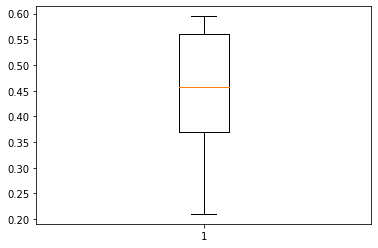

In [8]:
plt = matplotlib.pyplot.boxplot(results["F1"], notch=None, vert=None, patch_artist=None, widths=None)

